In [26]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from numpy import linalg as LA
from numpy.linalg import inv

# Data processing

In [27]:
# chose 25 folders randomly
chosen = np.random.default_rng(2022).choice(np.arange(1, 69), 25, replace=False)

# Load images 
images = []
labels = []

directory = Path("/Python_programme/Jupyter/PIE_origin")
for i in chosen:
    # split train and test
    sub_images = []
    sub_labels = []
    sub_directory = directory / str(i)
    
    files = list(sub_directory.glob("*.jpg"))
    np.random.default_rng(2023).shuffle(files)
    for filename in files:
        im = Image.open(filename)
        sub_images.append(np.array(im))
        sub_labels.append(i)  # Use folder numbers as labels
    images.append(sub_images)
    labels.append(sub_labels)
    
# len(images)
# len(labels)

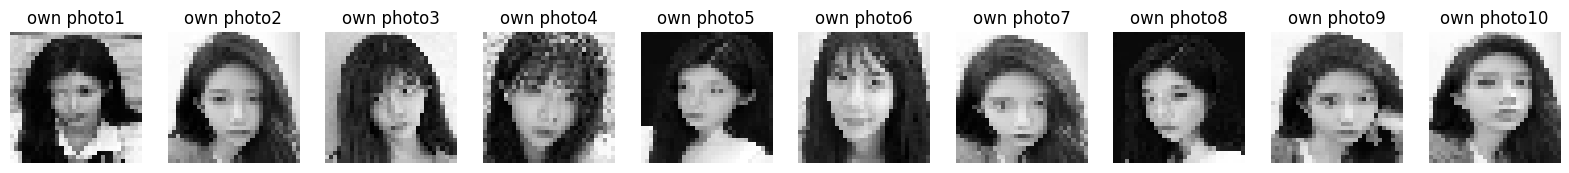

In [28]:
# process own photos
own_images= []
own_labels = []

for i in range(1, 11):
    img = cv2.imread('/Python_programme/Jupyter/own_photos/'+ str(i)+'.jpg', cv2.IMREAD_GRAYSCALE)  # convert to gray image
    img = cv2.resize(img, (32, 32), interpolation = cv2.INTER_CUBIC)
    own_images.append(img)   # create imgs in desired format
    own_labels.append(69)  # label own photos as class 69
    
# split training and testing data sets 
own_train_imgs = own_imgs[0:7]      # first 7 phots for training
own_test_imgs = own_imgs[7:]        # last 3 photos for testing
own_train_labels = own_labels[0:7]  
own_test_labels = own_labels[7:]

# visualize photos
fig = plt.figure(figsize = (20,10))

for i in range(1, 11):
    plt.subplot(1, 10, i)
    plt.imshow(own_imgs[i-1], cmap = 'gray' )
    plt.title('own photo'+ str(i))
    plt.axis('off')
    
plt.show()

In [29]:
# Train-test split
NUM_TRAIN_IMAGES_PER_SUBJECT = np.int_(np.around(0.7 * 170))

images_train, images_test = np.split(np.array(images), [NUM_TRAIN_IMAGES_PER_SUBJECT], axis=1)
labels_train, labels_test = np.split(np.array(labels), [NUM_TRAIN_IMAGES_PER_SUBJECT], axis=1)
own_images_train, own_images_test = np.split(np.array(own_imgs), [7])
own_labels_train, own_labels_test = np.split(np.array(own_labels), [7])

import warnings
warnings.filterwarnings('ignore', category=Warning)

# Flatterning
PIE_images_train = images_train.reshape(25*NUM_TRAIN_IMAGES_PER_SUBJECT, 1024)
own_images_train = own_images_train.reshape(7, 1024)
images_test = images_test.reshape(25*(170-NUM_TRAIN_IMAGES_PER_SUBJECT), 1024)
own_images_test = own_images_test.reshape(3, 1024)

labels_train = labels_train.reshape(25*NUM_TRAIN_IMAGES_PER_SUBJECT)
labels_test = labels_test.reshape(25*(170-NUM_TRAIN_IMAGES_PER_SUBJECT))

# Combine PIE images and own photos to get full train and test sets
full_train_set = np.append(PIE_images_train,own_images_train,axis=0,)
full_train_labels = np.append(labels_train, own_labels_train)

full_test_set = np.append(images_test,own_images_test,axis=0,)
full_test_labels = np.append(labels_test, own_labels_test)

# PCA

## 1. select 500 images from training set

In [30]:
chosen = np.random.default_rng(2020).choice(np.arange(2982), 500, replace=False)

X_train = full_train_set[chosen]
y_train = full_train_labels[chosen]

mean_X = np.mean(X_train, axis=0)
centered_X = X_train - mean_X

u, s, vh = np.linalg.svd(centered_X, full_matrices=False)
s_matrix = np.diag(s)

# max components: 200
X_pca = u[:, :200] @ s_matrix[:200, :200]

## 2. reduce dimension to 2 and visualize

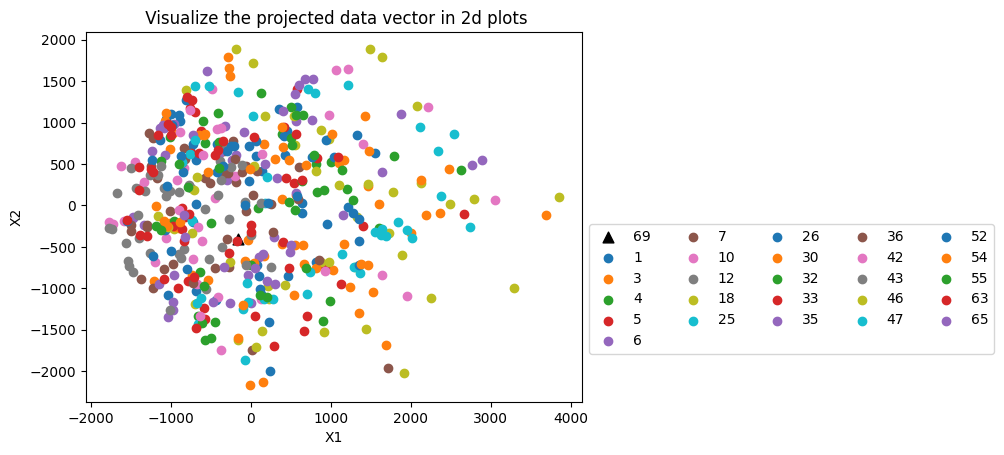

In [31]:
fig = plt.figure()
ax = fig.add_subplot()

# highlight point of own photos in dark triangle_up marker
ax.scatter(X_pca[y_train == 69][:, 0],X_pca[y_train == 69][:, 1],marker="^", label=69,c="k", s=60)
# show points for figures in PIE
for i in np.unique(y_train[y_train != 69]):
    ax.scatter(X_pca[y_train == i][:, 0], X_pca[y_train == i][:, 1], label=i)

ax.set_xlabel("X1")
ax.set_ylabel("X2")
lgd = ax.legend(ncol=np.int_(25 / 5), bbox_to_anchor=(1, 0.5))
ax.set_title(' Visualize the projected data vector in 2d plots')
plt.show()

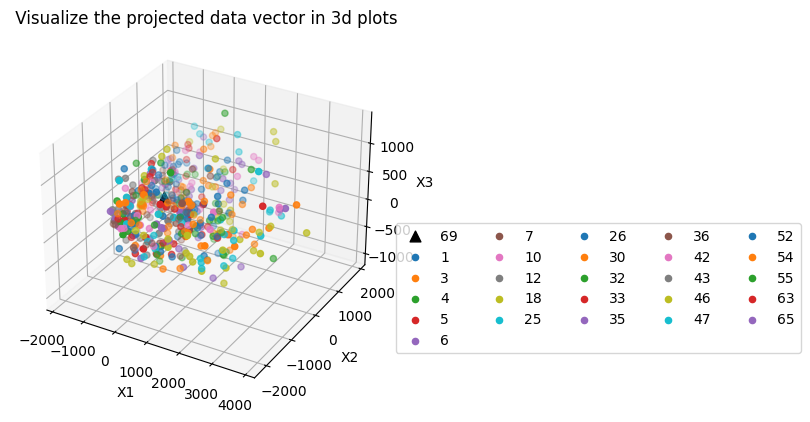

In [32]:
# 3D
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

# highlight point of own photos in dark triangle_up marker
ax.scatter(X_pca[y_train == 69][:, 0],X_pca[y_train == 69][:, 1],X_pca[y_train == 69][:, 2],
           marker="^",label=69,c="k", s=60)

for i in np.unique(y_train[y_train != 69]):
    ax.scatter(X_pca[y_train == i][:, 0],X_pca[y_train == i][:, 1],X_pca[y_train == i][:, 2],label=i,)

ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("X3")

lgd = ax.legend(ncol=np.int_(25 / 5), bbox_to_anchor=(1, 0.5))
ax.set_title(' Visualize the projected data vector in 3d plots')
plt.show()

## 3. Three eigenfaces

(-0.5, 31.5, 31.5, -0.5)

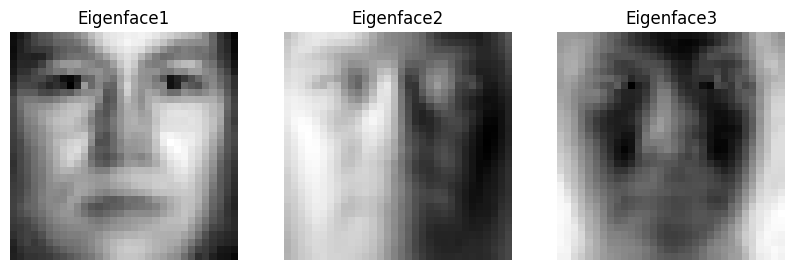

In [33]:
def ComputeEigenface(eigenface):
    normalized = (
        (eigenface - np.min(eigenface)) / (np.max(eigenface) - np.min(eigenface)) * 255
    )
    return Image.fromarray(normalized.astype("uint8").reshape(32, 32), "L")

#===========================================
face_1 = ComputeEigenface(vh[0])
face_2 = ComputeEigenface(vh[1])
face_3 = ComputeEigenface(vh[2])
# plot
plt.figure(figsize=(10,8))
plt.subplot(1, 3, 1)
plt.imshow(face_1, cmap = 'gray')
plt.title('Eigenface'+ str(1))
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(face_2, cmap = 'gray')
plt.title('Eigenface'+ str(2))
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(face_3, cmap = 'gray') 
plt.title('Eigenface'+ str(3))
plt.axis('off')

## 5. Classification and accuracy for 40, 80 and 200 dimensions

In [34]:
# Center test set (PIE)
mean_X_test = np.mean(images_test, axis=0)
centered_X_test = images_test - mean_X_test

# Center test set (own)
own_mean_X_test = np.mean(own_images_test, axis=0)
own_centered_X_test = own_images_test - own_mean_X_test

# PCA projection
X_pca_test = centered_X_test @ vh.T[:, :200]
own_X_pca_test = own_centered_X_test @ vh.T[:, :200]

In [36]:
def NN_classification(dim, X, y):
    dist_arr_test = LA.norm(X[:, :dim][:, np.newaxis] - X_pca[:, :dim], axis=2)
    dist_arr_test = np.argsort(dist_arr_test)  # get the indices (cols) in sorted order

    k = 1  # Unique person
    # Get knn indices then use them to access label
    knn_indices = dist_arr_test[:, :k]
    knn_labels = y_train[knn_indices]

    # Original rows (X values we want to check) are preserved, so we apply
    # KNN formula to each row, but ignore k since its constant here
    result = knn_labels[:, 0]
    acc = np.sum(result == y) / y.size

    return acc


def Accuracy(X, y):
    for i in [40, 80, 200]:
        print(
            "Accuracy with dim",
            i,
            "=",
            NN_classification(i, X, y),
        )

#===================================================
print("For PIE:")
Accuracy(X_pca_test, labels_test)
print("For own photos:")
Accuracy(own_X_pca_test, own_labels_test)

For PIE:
Accuracy with dim 40 = 0.6054901960784314
Accuracy with dim 80 = 0.6392156862745098
Accuracy with dim 200 = 0.6580392156862745
For own photos:
Accuracy with dim 40 = 0.0
Accuracy with dim 80 = 0.0
Accuracy with dim 200 = 0.0
